# Excerise Week 8 -- L16

In [1]:
# imports
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy.stats import shapiro, bartlett
from matplotlib import pyplot as plt
import pandas

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf

import pymannkendall as mk
# EVA
from pyextremes import EVA

# Load up data

In [2]:
data_file = '../Data/sanfrancisco_tmax_1895_2022.csv'

In [20]:
df = pandas.read_csv(data_file, skiprows=4)
df.head()

,Date,Value,Anomaly
0,194612,66.3,-0.6
1,194712,-99.0,-165.9
2,194812,65.8,-1.1
3,194912,65.6,-1.3
4,195012,66.9,0.0


# Date

In [21]:
dates = []
for item in df.Date:
    date = f'{str(item)[:4]}-{str(item)[-2:]}'
    dates.append(date)
dates = pandas.to_datetime(dates)
df['date'] = dates
df.set_index('date', inplace=True)
df.head()

,Date,Value,Anomaly
date,,,
1946-12-01,194612,66.3,-0.6
1947-12-01,194712,-99.0,-165.9
1948-12-01,194812,65.8,-1.1
1949-12-01,194912,65.6,-1.3
1950-12-01,195012,66.9,0.0


## Deal with bad data

In [22]:
bad = df.Value < 0.
good = np.invert(bad)
df['Value'][bad] = np.nan

/tmp/ipykernel_15483/2545451234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Value'][bad] = np.nan


## Plot

<AxesSubplot:xlabel='date'>

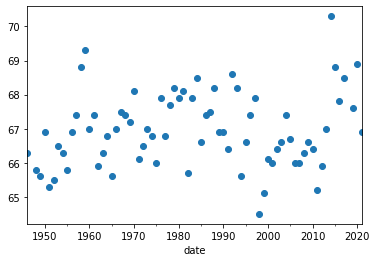

In [23]:
df['Value'].plot(marker='o', ls='')

# Sort

In [25]:
x_sort = np.sort(df.Value.values[good])
x_sort

array([64.5, 65.1, 65.2, 65.3, 65.5, 65.6, 65.6, 65.6, 65.7, 65.8, 65.8,
       65.9, 65.9, 66. , 66. , 66. , 66. , 66.1, 66.1, 66.3, 66.3, 66.3,
       66.3, 66.4, 66.4, 66.4, 66.5, 66.5, 66.6, 66.6, 66.6, 66.6, 66.7,
       66.8, 66.8, 66.8, 66.9, 66.9, 66.9, 66.9, 66.9, 67. , 67. , 67. ,
       67. , 67.2, 67.4, 67.4, 67.4, 67.4, 67.4, 67.4, 67.5, 67.5, 67.6,
       67.7, 67.8, 67.9, 67.9, 67.9, 67.9, 68.1, 68.1, 68.2, 68.2, 68.2,
       68.5, 68.5, 68.6, 68.8, 68.8, 68.9, 69.3, 70.3])

## $F(x)$

In [26]:
n=len(x_sort)
F_x=(np.arange(n)+1)/(n+1)

## Plot

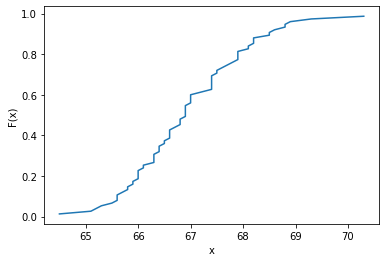

In [27]:
plt.clf()
ax = plt.gca()
ax.plot(x_sort, F_x)
#
ax.set_ylabel('F(x)')
ax.set_xlabel('x')
plt.show()

## Return Periods

In [28]:
T=1/(1-F_x)

### Plot

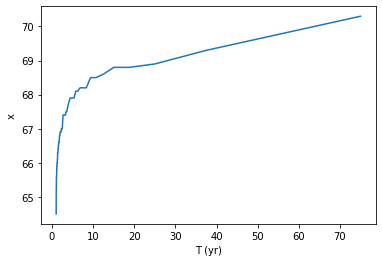

In [29]:
plt.clf()
ax = plt.gca()
ax.plot(T, x_sort)
#
ax.set_xlabel('T (yr)')
ax.set_ylabel('x')
plt.show()

# Fit EVD

## Model

In [38]:
series = (
    df.Value.sort_index(ascending=True)
    .astype(float)
    .dropna())

In [39]:
model = EVA(series)

In [40]:
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                         Value      Size:                                  74
Start:                      December 1946      End:                        December 2021
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Extreme values have not been extracted
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fit to the extremes

## Extract

In [42]:
model.get_extremes(method="BM", block_size="366.2425D", errors='ignore')

/home/xavier/miniconda3/lib/python3.9/site-packages/pyextremes/extremes/block_maxima.py:137: NoDataBlockWarning: 1 blocks contained no data
  warnings.warn(


(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='date', ylabel='Value'>)

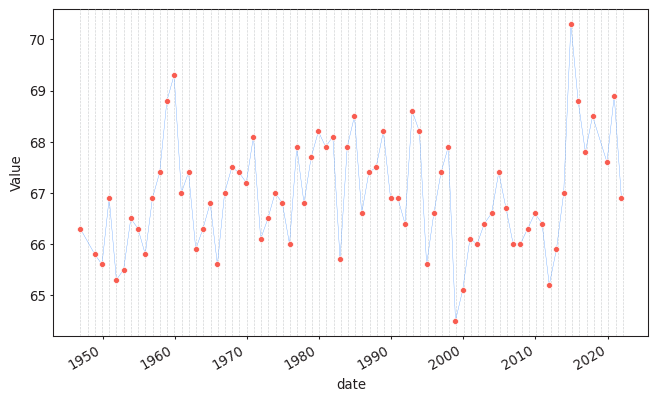

In [43]:
model.plot_extremes()

In [44]:
model.fit_model()

## Summary

In [47]:
summary = model.get_summary(
    return_period=[2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000,
)

In [48]:
summary

,return value,lower ci,upper ci
return period,,,
2.0,66.868519,66.610047,67.155639
5.0,67.849002,67.506509,68.163226
10.0,68.409032,67.972676,68.783572
25.0,69.029268,68.407147,69.560596
50.0,69.433798,68.644538,70.141689
100.0,69.793905,68.821777,70.707347
250.0,70.212202,68.983736,71.592380
500.0,70.490738,69.060434,72.248925
1000.0,70.740626,69.133141,72.962931


(<Figure size 768x768 with 4 Axes>,
 (<AxesSubplot:title={'center':'Return value plot'}, xlabel='Return period', ylabel='Value'>,
  <AxesSubplot:title={'center':'Probability density plot'}, xlabel='Value', ylabel='Probability density'>,
  <AxesSubplot:title={'center':'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <AxesSubplot:title={'center':'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

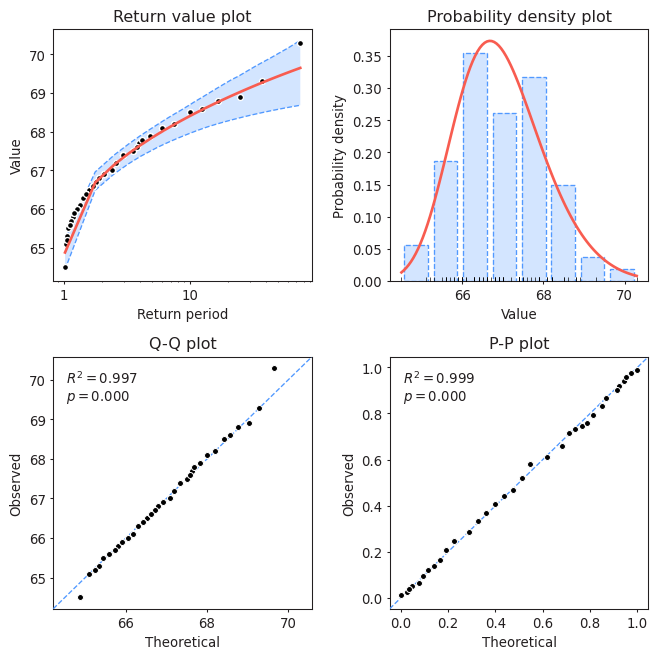

In [49]:
model.plot_diagnostic(alpha=0.95)